### I have shown that for a peptide with right shifted and right peaked score distribution must produce PDF greater than with the original kr distribution. And to select the right shifted and right peaked peptide based on their score distribution I wrote a function called ``candidate distribution`` which is given below. Here, I will compare order of these peptides based on score distributions from 3 different programs we used. In fact, we used PANPEP and ERGO-II, but ERGO-II can be divided into two categories for score prediction based on the prediction model trained on dataset either VDJDB or MCPAS.


In [1]:
import sys
root_dir = '/home/gddaslab/mxp140/tcr_project_ultimate'
sys.path.append(root_dir)
from constants import patient_names

In [34]:
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def candidate_distributions(data, topn: float = 0.1):
    if isinstance(data, pd.DataFrame):
        means = data.mean(axis=0).values
        skewnesses = data.skew(axis=0).values
    elif isinstance(data, np.ndarray):
        means = data.mean(axis=0)
        skewnesses = scipy.stats.skew(data, axis=0)
    else:
        raise ValueError("Data should be either a pandas DataFrame or a numpy array")

    # print("Means:", means)
    # print("Skewnesses:", skewnesses)

    best_indices = np.argsort(means)[::-1]  # Sort indices by mean in descending order

    best_distributions = [
        (i, means[i], skewnesses[i]) for i in best_indices if skewnesses[i] < 0
    ]

    topn_distributions = best_distributions[: int(len(best_distributions) * topn)]
    # print(
    #     f"Best {int(topn*100)}% distributions (Item, Mean, Skewness):",
    #     topn_distributions,
    # )
    print(f"Top {int(len(best_distributions) * topn)}/{data.shape[1]} were chosen.")
    return topn_distributions

Top 3/80 were chosen.
Top 4/80 were chosen.
Top 4/80 were chosen.


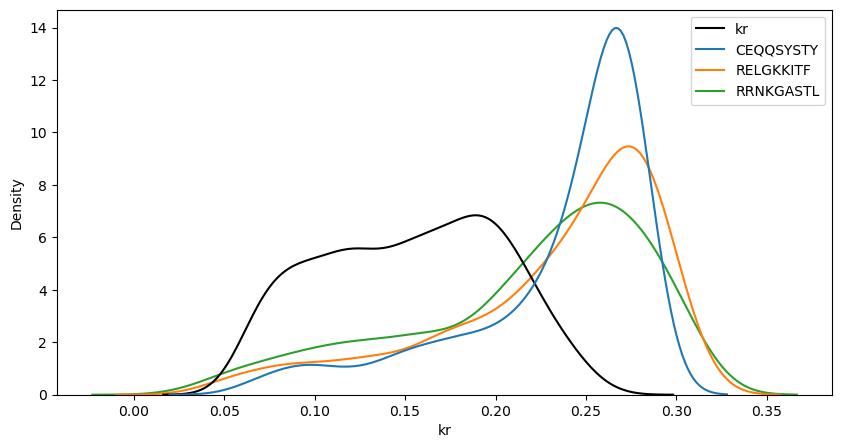

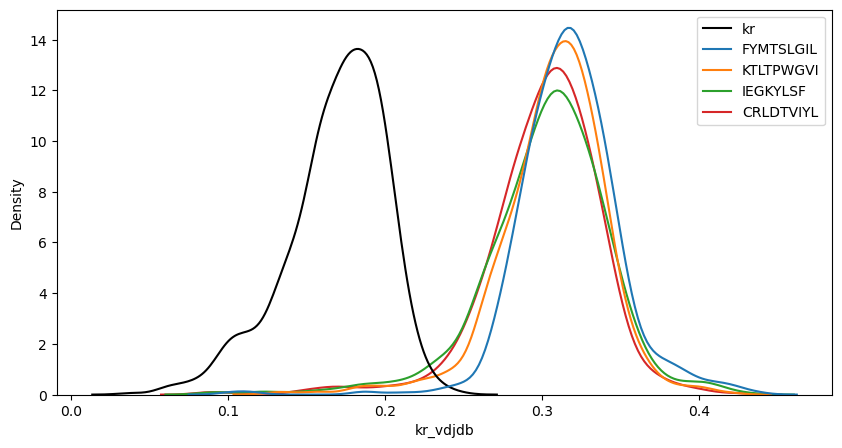

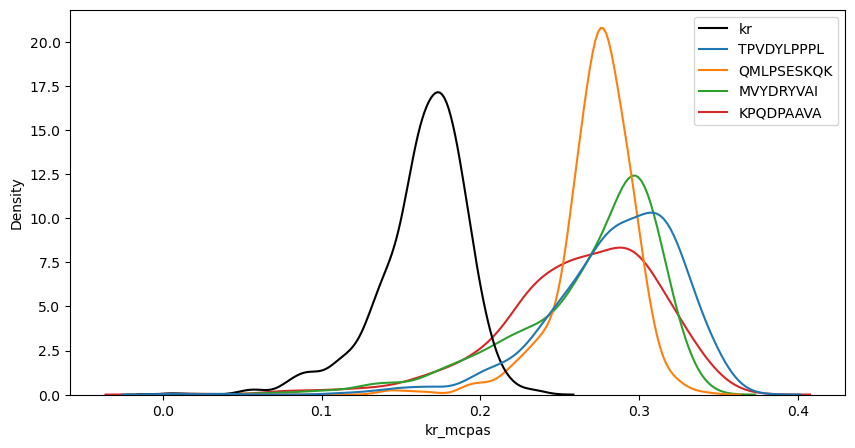

In [47]:
full_data_panpep = pd.read_csv(f'{root_dir}/data/BrMET_and_GBM_data-PANPEP.csv', sep=',')
full_data_vdjdb = full_data_mcpas = pd.read_csv(f'{root_dir}/data/BrMET_and_GBM_data-ERGOII.csv', sep=',')

max_kr_panpep = np.max(full_data_panpep['kr'].values)
max_kr_vdjdb = np.max(full_data_vdjdb['kr_vdjdb'].values)
max_kr_mcpas = np.max(full_data_mcpas['kr_mcpas'].values)

patient_id = patient_names[0]

region_level_data_panpep = pd.read_csv(f'{root_dir}/data/glioblastoma_data/PANPEP/{patient_id}/panpep_output_with_regions.csv', sep=',', comment='#')
region_level_data_vdjdb = region_level_data_mcpas = pd.read_csv(f'/home/gddaslab/mxp140/ERGO-II/{patient_id}_ergo2_output.csv', sep=',')

neoantigens_panpep = region_level_data_panpep['Peptide'].unique()
neoantigens_vdjdb = region_level_data_vdjdb['Peptide'].unique()
neoantigens_mcpas = region_level_data_mcpas['Peptide'].unique()

num_of_neoantigens_panpep = len(neoantigens_panpep)
num_of_neoantigens_vdjdb = len(neoantigens_vdjdb)
num_of_neoantigens_mcpas = len(neoantigens_mcpas)

num_of_tcr_panpep = region_level_data_panpep['CDR3'].nunique()
num_of_tcr_vdjdb = num_of_tcr_mcpas = region_level_data_vdjdb['TRB'].nunique()

################################# PANPEP ###################################################
score_array_panpep = np.empty((num_of_tcr_panpep, num_of_neoantigens_panpep))
for i, peptide in enumerate(neoantigens_panpep):
    req_df = region_level_data_panpep[region_level_data_panpep['Peptide']==peptide]
    score_array_panpep[:, i] = req_df['Score'].values*num_of_neoantigens_panpep
candidate_stats_panpep = candidate_distributions(score_array_panpep, topn=0.1)
candidate_peptides_panpep = [neoantigens_panpep[stat[0]] for stat in candidate_stats_panpep]
############################################################################################

################################# VDJDB ###################################################
score_array_vdjdb = np.empty((num_of_tcr_vdjdb, num_of_neoantigens_vdjdb))
for i, peptide in enumerate(neoantigens_vdjdb):
    req_df = region_level_data_vdjdb[region_level_data_vdjdb['Peptide']==peptide]
    score_array_vdjdb[:, i] = req_df['Score_vdjdb'].values*num_of_neoantigens_vdjdb
candidate_stats_vdjdb = candidate_distributions(score_array_vdjdb, topn=0.1)
candidate_peptides_vdjdb = [neoantigens_vdjdb[stat[0]] for stat in candidate_stats_vdjdb]
############################################################################################

################################# MCPAS ###################################################
score_array_mcpas = np.empty((num_of_tcr_mcpas, num_of_neoantigens_mcpas))
for i, peptide in enumerate(neoantigens_mcpas[:]):
    req_df = region_level_data_mcpas[region_level_data_mcpas['Peptide']==peptide]
    score_array_mcpas[:, i] = req_df['Score_mcpas'].values*num_of_neoantigens_mcpas
candidate_stats_mcpas = candidate_distributions(score_array_mcpas, topn=0.1)
candidate_peptides_mcpas = [neoantigens_mcpas[stat[0]] for stat in candidate_stats_mcpas]
############################################################################################

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
patient_data_panpep = full_data_panpep[full_data_panpep['Patient']==patient_id]
sns.kdeplot(patient_data_panpep['kr']/max_kr_panpep, ax=ax, color='black', linewidth=1.5, zorder=0, label='kr')
for i, peptide in enumerate(candidate_peptides_panpep):
    req_df = region_level_data_panpep[region_level_data_panpep['Peptide']==peptide]
    sns.kdeplot(req_df['Score']*num_of_neoantigens_panpep/max_kr_panpep, ax=ax, zorder=-1*i, label=f'{peptide}')
ax.legend(loc='best')
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
patient_data_vdjdb = full_data_vdjdb[full_data_vdjdb['Patient']==patient_id]
sns.kdeplot(patient_data_vdjdb['kr_vdjdb']/max_kr_vdjdb, ax=ax, color='black', linewidth=1.5, zorder=0, label='kr')
for i, peptide in enumerate(candidate_peptides_vdjdb):
    req_df = region_level_data_vdjdb[region_level_data_vdjdb['Peptide']==peptide]
    sns.kdeplot(req_df['Score_vdjdb']*num_of_neoantigens_vdjdb/max_kr_vdjdb, ax=ax, zorder=-1*i, label=f'{peptide}')
ax.legend(loc='best')
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
patient_data_mcpas = full_data_mcpas[full_data_mcpas['Patient']==patient_id]
sns.kdeplot(patient_data_mcpas['kr_mcpas']/max_kr_mcpas, ax=ax, color='black', linewidth=1.5, zorder=0, label='kr')
for i, peptide in enumerate(candidate_peptides_mcpas):
    req_df = region_level_data_mcpas[region_level_data_mcpas['Peptide']==peptide]
    sns.kdeplot(req_df['Score_mcpas']*num_of_neoantigens_mcpas/max_kr_mcpas, ax=ax, zorder=-1*i, label=f'{peptide}')
ax.legend(loc='best')
plt.show()

In [28]:
print(f'PANPEP: {candidate_peptides_panpep}')
print(f'VDJDB: {candidate_peptides_vdjdb}')
print(f'MCPAS: {candidate_peptides_mcpas}')

PANPEP: ['CEQQSYSTY', 'RELGKKITF', 'RRNKGASTL', 'CEECCKAF', 'VRKIPCLGF', 'RMIQILENM', 'EEFLLNDIF', 'YENAIYFL', 'SENEYGASW', 'IEGKYLSF', 'FREDSAYEF', 'VANPDGFAF', 'KTLTPWGVI', 'LRLSYRPAF', 'HRLGPGTRL', 'FYMTSLGIL', 'DEYFLYAKN', 'KPQVCLPF', 'MMFSSTINL', 'KPRRRRAADV', 'SWIDGVLDM', 'FYFCNHFCI', 'AILLDGYSW', 'MVYDRYVAI', 'FRVPLTVLL', 'MFHSDFQHL', 'AFSSHAYLL', 'ITACFTQLF', 'ETWGMRTTL', 'VVLSASTTF', 'IYGIYIHVF', 'IPGDCGPPL', 'YEACLILGV', 'GPRGVQGL', 'NIFILSNRW']
VDJDB: ['FYMTSLGIL', 'KTLTPWGVI', 'IEGKYLSF', 'CRLDTVIYL', 'IYGIYIHVF', 'HRLGPGTRL', 'MMFSSTINL', 'FFQPFMSPL', 'FYFCNHFCI', 'GPRGVQGL', 'ETWGMRTTL', 'FPRMLTTRGQ', 'NIFILSNRW', 'YEWDECGRAF', 'MPGWCCRCSL', 'IPGDCGPPL', 'MFHSDFQHL', 'DEYFLYAKN', 'YPRRIQLSRM', 'SWIDGVLDM', 'VRKIPCLGF', 'FWLPPDPSL', 'TPRTEPDSWM', 'MVYDRYVAI', 'CEQQSYSTY', 'RPVMMVISHSA', 'AILLDGYSW', 'SPLYPGGPR', 'SENEYGASW', 'SPRQINYIRSL', 'TPVDYLPPPL', 'LRLSYRPAF', 'EQFSVFNTI', 'YEACLILGV', 'RRNKGASTL', 'YENAIYFL', 'SIKKPVPGK', 'FRVPLTVLL', 'SVQIIFLPF', 'SPLPCRSAY', 'APQA